In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/train_ZoGVYWq.csv")
test = pd.read_csv("../data/test_66516Ee.csv")
submission = pd.read_csv("../data/sample_submission_sLex1ul.csv")

# Setup Data

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [4]:
#SETUP DATA
data = pd.concat([train, test], axis=0).reset_index(drop = True)
data["sourcing_channel"] = LabelEncoder().fit_transform(data["sourcing_channel"])
data["residence_area_type"] = LabelEncoder().fit_transform(data["residence_area_type"])

In [5]:
train = data[:train.shape[0]].reset_index(drop =True)
test = data[train.shape[0]:].reset_index(drop =True)

train_id = train[["id"]]
test_id = test[["id"]]
target = train.renewal

train = train.drop(["id","renewal"], axis=1)
test = test.drop(["id","renewal"], axis=1)

# Running  Model

In [6]:
import lightgbm as lgb
def model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train,categorical_feature = ["sourcing_channel","residence_area_type"])
    dval = lgb.Dataset(x_test, label=y_test, categorical_feature = ["sourcing_channel","residence_area_type"])
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"auc",
        "objective": "binary",
        "learning_rate":0.15,
        "num_leaves":5,
        "max_depth":5,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 1341313,
        "seed":3414231
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))
    
    global meta_train_tid
    meta_train_tid[train_index] = model.predict(x_train, num_iteration=model.best_iteration or 5000)

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [7]:
meta_train = np.zeros(train.shape[0])
meta_train_tid = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=134334)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_lgb(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", roc_auc_score(target, meta_train)

test_id["renewal"] = pd.DataFrame(np.array(meta_test).T).rank(pct = True, axis=0).mean(axis=1)
train_id["renewal"] = meta_train
train_id["renewal_tid"] = meta_train_tid

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.851158	valid_1's auc: 0.845134
[200]	training's auc: 0.859029	valid_1's auc: 0.844259
Early stopping, best iteration is:
[89]	training's auc: 0.850492	valid_1's auc: 0.845404
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.854016	valid_1's auc: 0.838714
[200]	training's auc: 0.861227	valid_1's auc: 0.836585
Early stopping, best iteration is:
[54]	training's auc: 0.848372	valid_1's auc: 0.839863
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.852076	valid_1's auc: 0.845581
[200]	training's auc: 0.859808	valid_1's auc: 0.844644
Early stopping, best iteration is:
[92]	training's auc: 0.851362	valid_1's auc: 0.845976
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.852022	valid_1's auc: 0.845624
[200]	training's auc: 0.861357	valid_1's auc: 0.84352
Early stopping, best iteration is:
[76]	tr

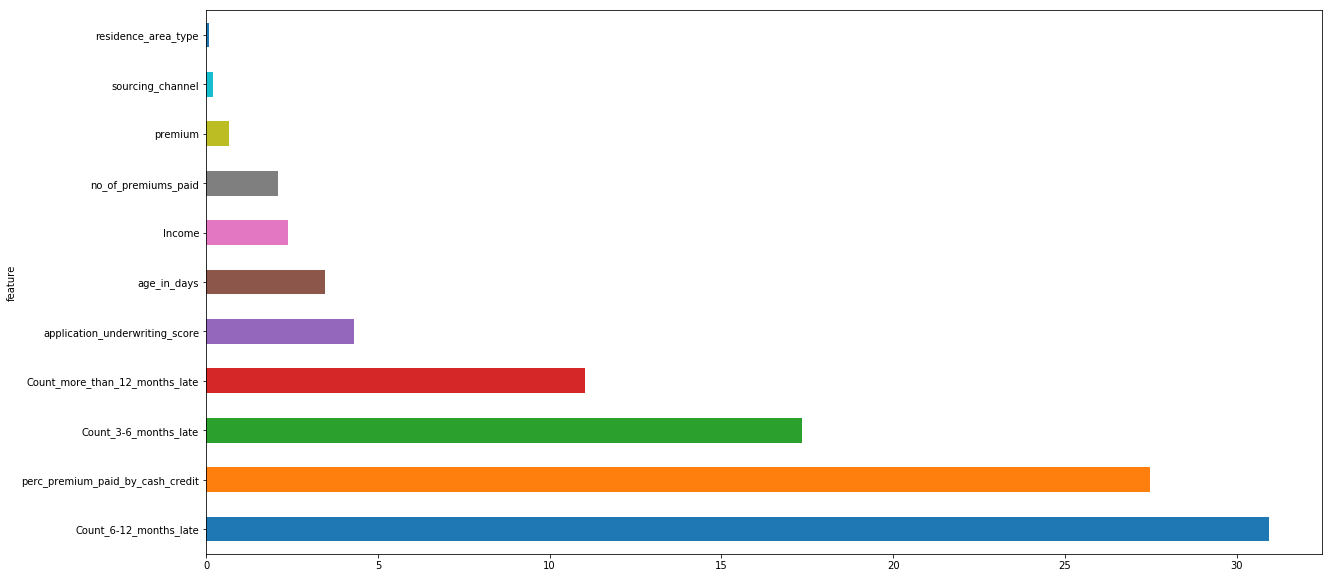

In [8]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


# Working on Incentives

In [9]:
def get_effort(incentive):
    return 10*(1-np.exp(-incentive/400.0))
    
def get_improvement_in_renewal_probability(incentive):
    effort = get_effort(incentive)
    return 20*(1-np.exp(-effort/5.0))

def gradient_improvement_in_renewal_probability(incentive):
    dpde = 4 * np.exp(-get_effort(incentive)/5.0)
    dedi = np.exp(-incentive/400.0)/40.0
    dpdi = dpde * dedi
    return  dpdi
    
def revenue_score(incentive, benchmark, premium):
    cdp = get_improvement_in_renewal_probability(incentive)
    profits = ((benchmark + (cdp*benchmark/100.0)) * premium)-incentive
    return np.sum(profits)

def score_gradient(incentive, benchmark, premium):
    z=  np.exp(-incentive/400.0)-(incentive/400.0)-2
    return ((benchmark * premium * np.exp(z)/400.0)-1)

def second_score_gradient(incentive, benchmark, premium):
    a = np.exp(-incentive/400.0)-(incentive/400.0)
    b = (benchmark* premium* np.exp(a))/400.0
    return (-(b)-(1.0/400.0))/400.0

def learn(benchmark, premium, early_stopping = 5, start_incentive = 1700, min_improvement = 0.005, verbose = True):
    incentive = start_incentive
    best_incentive = start_incentive
    
    score = 0
    best_score = 0
    
    counter = 0
    best_counter = 0
    no_improvement_counter = 0
    
    while True:
        lr = (incentive - 0)
        gradient = score_gradient(incentive, benchmark, premium)
        try:
            incentive += lr*(gradient*0.5 + 0.5*prev_gradient)
        except:
            incentive += lr*gradient
            
        
        score = revenue_score(incentive, benchmark, premium)
        counter +=1
        prev_gradient = gradient

        if (score-best_score> min_improvement):
            best_score = score
            best_incentive = incentive
            best_counter = counter
            
            no_improvement_counter = 0
            if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
        else:
            if (no_improvement_counter > early_stopping):
                if verbose: print "Early Stopping, Best Iteration Round: {}".format(best_counter)
                return best_incentive, best_score
            else:
                no_improvement_counter +=1
                if verbose: print "Epoch: {}, Incentive: {}, Score: {}, Gradient: {}".format(counter,incentive, score, gradient)
    

In [10]:
def annealing(benchmark, premium, num_annealing = 30):
    results = []
    for incentive in range(0,premium,int(float(premium)/num_annealing)):
        results.append(learn(benchmark, premium, early_stopping = 5, start_incentive = incentive, min_improvement = 0.005, verbose = False))
    return sorted(results, key = lambda x: x[1])[-1][0]    

In [11]:
train_incentives = []

for i, (benchmark, premium) in enumerate(zip(train_id["renewal_tid"], train["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    train_incentives.append(annealing(benchmark, premium))
    
train_incentives = pd.Series(train_incentives)
train_incentives[train_incentives<0] = 0

generated_score = revenue_score(train_incentives, train_id["renewal_tid"], train["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(train_incentives)), train_id["renewal_tid"], train["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Completed 40000 Rows
Completed 50000 Rows
Completed 60000 Rows
Completed 70000 Rows
Score using generated Incentive: 917464045.845
Score using 1650 as Incentive: 834980587.04
Score Improvement: 1.09878488205


In [12]:
test_incentives = []

for i, (benchmark, premium) in enumerate(zip(test_id["renewal"], test["premium"])):
    if i%10000 == 0: print "Completed {} Rows".format(i)
    test_incentives.append(annealing(benchmark, premium))
    
test_incentives = pd.Series(test_incentives)
test_incentives[test_incentives<0] = 0

generated_score = revenue_score(test_incentives, test_id["renewal"], test["premium"])
baseline_score = revenue_score(pd.Series([1650]*len(test_incentives)), test_id["renewal"], test["premium"])

print "Score using generated Incentive:",generated_score
print "Score using 1650 as Incentive:",baseline_score
print "Score Improvement:", generated_score/baseline_score

Completed 0 Rows
Completed 10000 Rows
Completed 20000 Rows
Completed 30000 Rows
Score using generated Incentive: 215349653.952
Score using 1650 as Incentive: 173563130.919
Score Improvement: 1.24075690967


# Training for Incentives

In [13]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        "nthread":8,
        "bagging_fraction": 0.85,
        "feature_fraction": 0.85,
        "bagging_freq": 200,
        "metric":"rmse",
        "objective": "regression",
        "learning_rate":0.05,
        "num_leaves":10,
        "max_depth":10,
        "silent":-1,
        "verbose":-1,
        "bagging_seed" : 433432,
        "seed":353523
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    meta_test.append(model.predict(test, num_iteration=model.best_iteration or 5000))

    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    feature_importance = feature_importance.append(pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}), ignore_index=True)

In [14]:
train["prediction"] = train_id["renewal"]
test["prediction"] = train_id["renewal"]

meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame(columns = ["feature","split","gain"])

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=763474)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = train_incentives[train_index], train_incentives[test_index]

    model_lgb_regression(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)

print "Overall Score:", mean_squared_error(train_incentives, meta_train)
test_id["incentives"] = np.array(meta_test).T.mean(axis=1)
train_id["incentives"] = meta_train

test_id["incentives"] += test_incentives
test_id["incentives"] /= 2

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 13.1434	valid_1's rmse: 12.9508
[200]	training's rmse: 10.8325	valid_1's rmse: 10.7859
[300]	training's rmse: 10.2119	valid_1's rmse: 10.3583
[400]	training's rmse: 9.79732	valid_1's rmse: 10.1135
[500]	training's rmse: 9.47988	valid_1's rmse: 9.97825
[600]	training's rmse: 9.20118	valid_1's rmse: 9.89221
[700]	training's rmse: 8.93376	valid_1's rmse: 9.78113
[800]	training's rmse: 8.73076	valid_1's rmse: 9.72227
[900]	training's rmse: 8.53231	valid_1's rmse: 9.66398
[1000]	training's rmse: 8.36942	valid_1's rmse: 9.60799
[1100]	training's rmse: 8.21405	valid_1's rmse: 9.59606
[1200]	training's rmse: 8.08701	valid_1's rmse: 9.5663
[1300]	training's rmse: 7.96467	valid_1's rmse: 9.53249
[1400]	training's rmse: 7.84994	valid_1's rmse: 9.48538
[1500]	training's rmse: 7.72789	valid_1's rmse: 9.45487
[1600]	training's rmse: 7.62583	valid_1's rmse: 9.44113
[1700]	training's rmse: 7.52156	valid_1's rmse: 9.3

[2900]	training's rmse: 6.44722	valid_1's rmse: 10.1508
[3000]	training's rmse: 6.39318	valid_1's rmse: 10.1367
[3100]	training's rmse: 6.32325	valid_1's rmse: 10.1112
[3200]	training's rmse: 6.27806	valid_1's rmse: 10.0954
[3300]	training's rmse: 6.21982	valid_1's rmse: 10.0831
[3400]	training's rmse: 6.17161	valid_1's rmse: 10.0672
[3500]	training's rmse: 6.1206	valid_1's rmse: 10.0706
[3600]	training's rmse: 6.07825	valid_1's rmse: 10.068
Early stopping, best iteration is:
[3402]	training's rmse: 6.17067	valid_1's rmse: 10.0671
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 12.8547	valid_1's rmse: 13.6733
[200]	training's rmse: 10.5447	valid_1's rmse: 11.5722
[300]	training's rmse: 9.92599	valid_1's rmse: 11.1935
[400]	training's rmse: 9.50339	valid_1's rmse: 10.9534
[500]	training's rmse: 9.20587	valid_1's rmse: 10.8027
[600]	training's rmse: 8.95404	valid_1's rmse: 10.6647
[700]	training's rmse: 8.72892	valid_1's rmse: 10.5275
[800]	training'

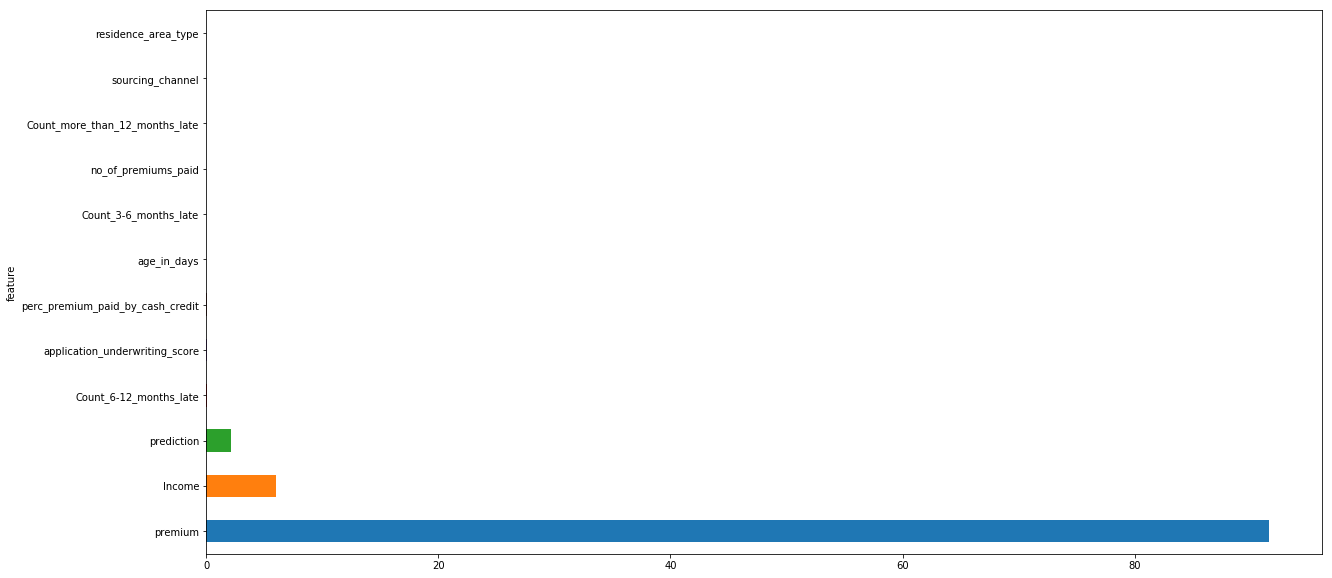

In [15]:
# Print Feature Importance
feature_importance = feature_importance.groupby("feature")["gain"].mean().reset_index().sort_values('gain', ascending=False).reset_index(drop=True)
plt.figure()
feature_importance[['feature','gain']].head(60).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(20, 10));


In [16]:
submission = submission[["id"]].merge(test_id[["id","renewal","incentives"]], how = "left", on = "id")
submission = submission[["id", "renewal", "incentives"]]
submission.loc[submission.incentives < 0,"incentives"] = 0
submission.to_csv("csv/eda3.csv", index=False)

In [17]:
submission

id   renewal  incentives
0         649  0.952878  177.387538
1       81136  0.676686  399.658639
2       70762  0.157132  244.683390
3       53935  0.497654  209.895129
4       15476  0.396833  298.036552
5       64797  0.716471  400.500944
6       67412  0.097096   79.538817
7       44241  0.084935  125.230191
8        5069  0.914434  470.784740
9       16615  0.930736  667.063110
10      84281  0.783877  548.424886
11      82623  0.406352    9.801546
12      86475  0.022698  169.788334
13      68263  0.401163   10.381184
14     113135  0.325891    7.859445
15      45532  0.492698  459.142808
16     102161  0.979921  341.445651
17      84789  0.038248  328.928312
18      62398  0.499909  366.625569
19      70148  0.684683  160.896376
20     102487  0.231475  322.463665
21     100513  0.191579  275.190144
22      92702  0.186135  142.764000
23      25051  0.036916  165.366091
24      92920  0.930850  474.533972
25      25520  0.377460  338.152882
26      81869  0.384429  628.338001
27      75402  0.698983  305.260815
28      34053  0.028138    0.000000
29      21191  0.748980  365.317015
...       ...       ...         ...
34194   79950  0.695041  303.011348
34195   30272  0.938657   20.039087
34196   85914  0.994416  486.831995
34197   10922  0.744779  448.392525
34198   93046  0.725844  254.092500
34199   52826  0.335750  422.545557
34200   35994  0.763590  673.224753
34201    1512  0.769329  249.163160
34202   52077  0.428658  255.157566
34203   95749  0.593858  289.173582
34204   49946  0.739303  153.638565
34205   66811  0.660905  351.027416
34206   53438  0.903398   16.707822
34207   24435  0.719364  539.159139
34208   17848  0.498770  408.639341
34209   53626  0.625345  231.593796
34210   87268  0.911095  473.177494
34211   58450  0.558348   10.072062
34212   48188  0.729164  583.915733
34213   44239  0.490702  362.648035
34214   24582  0.279999  218.961582
34215   79939  0.360124   99.441744
34216   63759  0.464697   10.954172
34217   63725  0.037743   75.609065
34218   37116  0.407837  490.384076
34219   81988  0.420588  193.077873
34220   30326  0.604421   12.304715
34221   65749  0.336694   10.014281
34222   65686  0.050760  227.377207
34223   93826  0.381858  182.327963

[34224 rows x 3 columns]